# Assignment 2 - Machine Learning
## FEUP MIEIC - Inteligência Artificial *(EIC0029/IART)*



## K-Nearest Neighbor partial notebook

This Jupyter Notebook implpementes and documents a K-Nearest Neighbor machine Learning model. <br><br>
*The content of this notebook will be also included in the complete notebook named **IART-MachineLearning.ipynb** that can be found in the root directory of this repository*

***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

In [2]:
# Connecting to database
database = "database.sqlite"
con = sqlite3.connect(database)
pd.set_option('display.max_columns', None)

In [3]:
#Get important tables from db
matches_df = pd.read_sql("""SELECT * from MATCH""", con)
teams_df = pd.read_sql("""SELECT * from TEAM""", con)
player_attributes_df = pd.read_sql("""SELECT * from PLAYER_ATTRIBUTES""", con)
team_attributes_df = pd.read_sql("""SELECT * from TEAM_ATTRIBUTES""", con)

In [4]:
#Get players' attributes (overall)

#Get players info
home_players = ["home_player_" + str(x) for x in range(1, 12)]
away_players = ["away_player_" + str(x) for x in range(1, 12)]

matches_kept_columns = ["id", "league_id", "date", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal"]
matches_kept_columns = matches_kept_columns + home_players
matches_kept_columns = matches_kept_columns + away_players

matches_df = matches_df[matches_kept_columns]

#Get overall ratings for all players from player_attributes table
for player in home_players:
    matches_df = pd.merge(matches_df, player_attributes_df[["id", "overall_rating"]], left_on=[player], right_on=["id"], suffixes=["", "_" + player])
for player in away_players:
    matches_df = pd.merge(matches_df, player_attributes_df[["id", "overall_rating"]], left_on=[player], right_on=["id"], suffixes=["", "_" + player])
 

matches_df = matches_df.rename(columns={"overall_rating": "overall_rating_home_player_1"})

matches_df['overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].sum(axis=1)
matches_df['overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].sum(axis=1)
matches_df['overall_rating_difference'] = matches_df['overall_rating_home'] - matches_df['overall_rating_away']

matches_df['mean_overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].mean(axis=1)
matches_df['mean_overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].mean(axis=1)


#Remove all players column because we just need the "global" ones
for c in matches_df.columns:
    if '_player_' in c:
        matches_df = matches_df.drop(c, axis=1)


In [5]:
#function to calculate last 5 games performance
def last5(team_id, date, match_t):
     
    mat = match_t[(match_t['date'] < date)]
    mat = mat[mat['home_team_api_id'] == team_id]
    
    mat5 = mat.head(5)
    if len(mat5.index) < 5:
        return -1
    mat5['Home result'] = 0
    mat5['Home result'] = np.where(mat5['home_team_goal'] > mat5['away_team_goal'], 3, mat5['Home result'])
    mat5['Home result'] = np.where(mat5['home_team_goal'] == mat5['away_team_goal'], 1, mat5['Home result'])
    total = mat5['Home result'].sum()
    return total

match_t = matches_df[['home_team_api_id', 'away_team_api_id','date', 'home_team_goal', 'away_team_goal']].copy()
match_t['date'] = pd.to_datetime(match_t['date'])
match_t.sort_values(by=['date'], inplace=True, ascending=False) 
matches_df['Home_last5'] = 0
matches_df['Away_last5'] = 0
perc = 0
for i in matches_df.index:
    Htotal = last5(match_t['home_team_api_id'].iloc[i], match_t['date'].iloc[i], match_t)
    Atotal = last5(match_t['away_team_api_id'].iloc[i], match_t['date'].iloc[i], match_t)
    matches_df['Home_last5'].values[i] = Htotal
    matches_df['Away_last5'].values[i] = Atotal
    if i % 655 == 0:
        perc += 10
        print(" ", perc, "%", end=" ")
#Dont considerate games that dont have 5 previous history 
matches_df = matches_df[matches_df.Home_last5 != -1]
matches_df = matches_df[matches_df.Away_last5 != -1]

10 %  20 %  30 %  40 %  50 %  60 %  70 %  80 %  90 %  100 %

In [6]:
matches_aux = pd.read_sql("""SELECT * FROM MATCH""" ,con)

#Select all bet columns (removed PSA, PSH, PSD because they are almost all NaN)
bet_columns = ["B365H", "B365A", "B365D", "BWH", "BWD", "BWA", "IWH", "IWD", "IWA", "LBH", "LBD", "LBA", "WHH", "WHD", "WHA", "SJH", "SJD", "SJA", "VCH", "VCD", "VCA", "GBH", "GBD", "GBA", "BSH", "BSD", "BSA"]

#Get specific columns for bets on home and draw
bet_columns_home = ["B365H", "BWH","IWH", "LBH", "WHH", "SJH", "VCH", "GBH","BSH"]
bet_columns_draw = ["B365D", "BWD","IWD", "LBD", "WHD", "SJD", "VCD", "GBD","BSD"]

#Calculate mean values for bets on home team and draw. Add these values to match table
matches_df['mean_bets_home'] = matches_aux[bet_columns_home].mean(axis=1)
matches_df['mean_bets_draw'] = matches_aux[bet_columns_draw].mean(axis=1)

In [7]:
#Replace NaN values (on bets) with mean values 
matches_df.fillna(matches_df.mean(), inplace=True)
matches_df.isnull().sum()

id                           0
league_id                    0
date                         0
home_team_api_id             0
away_team_api_id             0
home_team_goal               0
away_team_goal               0
overall_rating_home          0
overall_rating_away          0
overall_rating_difference    0
mean_overall_rating_home     0
mean_overall_rating_away     0
Home_last5                   0
Away_last5                   0
mean_bets_home               0
mean_bets_draw               0
dtype: int64

In [8]:
#Get goal difference
matches_df['goal_diff'] = matches_df['home_team_goal'] - matches_df['away_team_goal']

matches_df['Game Result'] = 'Defeat'
matches_df['Game Result'] = np.where(matches_df['goal_diff'] == 0, 'Draw', matches_df['Game Result'])
matches_df['Game Result'] = np.where(matches_df['goal_diff'] > 0, 'Win', matches_df['Game Result'])

matches_df = matches_df.drop([ 'id', 'league_id', 'date', 'home_team_api_id','away_team_api_id','home_team_goal','away_team_goal','overall_rating_home', 'overall_rating_away', 'overall_rating_difference', 'goal_diff'], axis=1)

In [9]:
y = matches_df['Game Result']
X = matches_df.drop('Game Result', axis=1)


In [10]:
# apply regular SMOTE
method = SMOTE()
X, y = method.fit_sample(X, y)
#Train set selection
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)


In [11]:
#Normalization
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

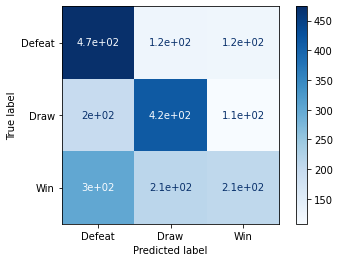

In [17]:
knn = KNeighborsClassifier(n_neighbors = 3).fit(X_train_scaled,y_train)

knn_M = plot_confusion_matrix(knn,X_test_scaled, y_test, cmap=plt.cm.Blues)
knn_M


In [18]:
y_pred = knn.predict(X_test_scaled)

print("knn Accuracy score: ", accuracy_score(y_test, y_pred))
print("\nknn Report:")
print(classification_report(y_test, y_pred))

knn Accuracy score:  0.5071726052753355

knn Report:
              precision    recall  f1-score   support

      Defeat       0.49      0.66      0.56       720
        Draw       0.55      0.58      0.56       720
         Win       0.47      0.29      0.36       721

    accuracy                           0.51      2161
   macro avg       0.50      0.51      0.49      2161
weighted avg       0.50      0.51      0.49      2161



In [14]:
#search for optimal parameters

grid_param = {
    'n_neighbors': [3, 5, 7, 11, 19],
    'weights':['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

#use gridsearch to test all values for n_neighbors
knn_best = GridSearchCV(KNeighborsClassifier(), grid_param, verbose = False, cv=3, n_jobs = -1)
#fit model to data
knn_best_result = knn_best.fit(X_test_scaled, y_test)

#check top performing n_neighbors value
knn_best.best_params_
#knn_best.best_score_
#knn_best.best_estimator_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

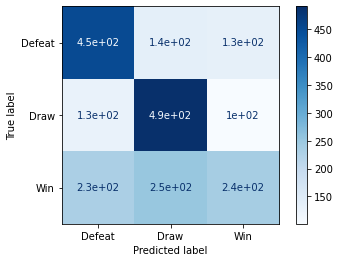

In [15]:
#best KNN

knnfinal = KNeighborsClassifier(n_neighbors = 5, metric='manhattan', weights='distance').fit(X_train_scaled,y_train)

CM_B = plot_confusion_matrix(knnfinal,X_test_scaled, y_test, cmap=plt.cm.Blues)
CM_B


In [16]:


y_pred = knnfinal.predict(X_test_scaled)

print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("\nReport:")
print(classification_report(y_test, y_pred))

Accuracy score:  0.5451180009254974

Report:
              precision    recall  f1-score   support

      Defeat       0.56      0.62      0.59       720
        Draw       0.56      0.68      0.61       720
         Win       0.50      0.33      0.40       721

    accuracy                           0.55      2161
   macro avg       0.54      0.55      0.53      2161
weighted avg       0.54      0.55      0.53      2161

